In [1]:
import math
from scipy.special import comb

def ensemble_error(n_classifiers, classifier_error):
    """
    Calculate the ensemble error.
    
    Parameters:
    n_classifiers (int): The number of classifiers.
    classifier_error (float): The error rate of a single classifier.
    
    Returns:
    float: The ensemble error.
    """
    k_start = math.ceil((n_classifiers + 1) / 2)
    ensemble_err = sum(comb(n_classifiers, k) * 
                       (classifier_error ** k) * 
                       ((1 - classifier_error) ** (n_classifiers - k)) 
                       for k in range(k_start, n_classifiers + 1))
    return ensemble_err

# Example usage
n_classifiers = 11
classifier_error = 0.25
print(f'Ensemble error with {n_classifiers} classifiers each having error {classifier_error}: {ensemble_error(n_classifiers, classifier_error):.3f}')

Ensemble error with 11 classifiers each having error 0.25: 0.034


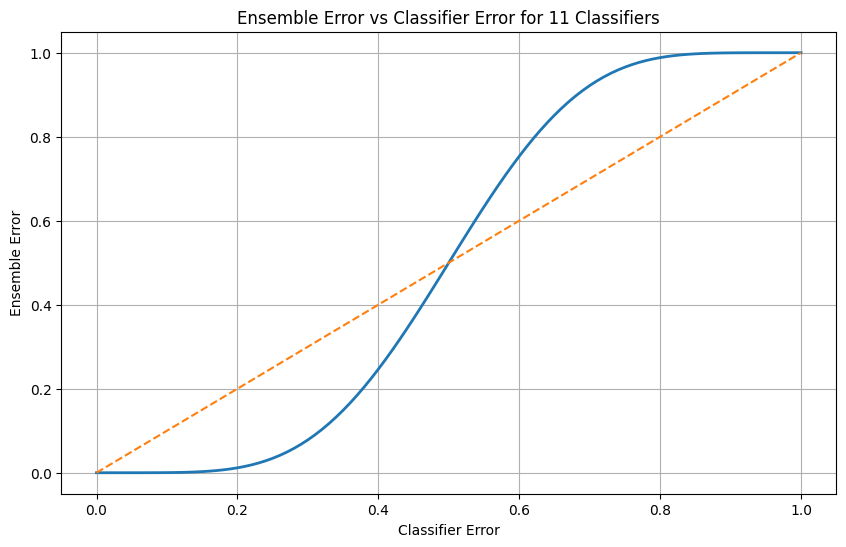

In [2]:
import matplotlib.pyplot as plt
import numpy as np
# Parameters
classifier_errors = np.arange(0.0, 1.01, 0.01)

# Calculate ensemble errors
ensemble_errors = [ensemble_error(n_classifiers, error) for error in classifier_errors]

# Plotting the results
plt.figure(figsize=(10, 6))
plt.plot(classifier_errors, ensemble_errors, linewidth=2)
plt.plot(classifier_errors, classifier_errors, linestyle='--')
plt.xlabel('Classifier Error')
plt.ylabel('Ensemble Error')
plt.title(f'Ensemble Error vs Classifier Error for {n_classifiers} Classifiers')
plt.grid(True)
plt.show()

In [3]:
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.preprocessing import LabelEncoder
from sklearn.base import clone
from sklearn.pipeline import _name_estimators
import numpy as np

class MajorityVoteClassifier(BaseEstimator, ClassifierMixin):
    """
    A majority vote ensemble classifier
    
    Parameters:
    ----------
    classifiers : array-like, shape = [n_classifiers]
        Different classifiers for the ensemble
    vote : str, {'classlabel', 'probability'} (default='classlabel')
        If 'classlabel' the prediction is based on the argmax of class labels.
        If 'probability' the prediction is based on the argmax of the sum of probabilities.
    weights : array-like, shape = [n_classifiers], optional (default=None)
        If a list of `int` or `float` values are provided, the classifiers
        are weighted by importance; Uses uniform weights if `weights=None`.
    """
    
    def __init__(self, classifiers, vote='classlabel', weights=None):
        self.classifiers = classifiers
        self.named_classifiers = {key: value for key, value in _name_estimators(classifiers)}
        self.vote = vote
        self.weights = weights
    
    def fit(self, X, y):
        """
        Fit classifiers.
        
        Parameters:
        ----------
        X : {array-like, sparse matrix}, shape = [n_samples, n_features]
            Matrix of training samples.
        y : array-like, shape = [n_samples]
            Vector of target class labels.
            
        Returns:
        -------
        self : object
        """
        if self.vote not in ('probability', 'classlabel'):
            raise ValueError(f"vote must be 'probability' or 'classlabel'; got (vote={self.vote})")
        
        if self.weights and len(self.weights) != len(self.classifiers):
            raise ValueError(f'Number of classifiers and weights must be equal; got {len(self.weights)} weights, {len(self.classifiers)} classifiers')
        
        # Use LabelEncoder to ensure class labels are 0, 1, 2, ...
        self.lablenc_ = LabelEncoder()
        self.lablenc_.fit(y)
        self.classes_ = self.lablenc_.classes_
        self.classifiers_ = []
        for clf in self.classifiers:
            fitted_clf = clone(clf).fit(X, self.lablenc_.transform(y))
            self.classifiers_.append(fitted_clf)
        return self
    
    def predict(self, X):
        """
        Predict class labels for X.
        
        Parameters:
        ----------
        X : {array-like, sparse matrix}, shape = [n_samples, n_features]
            Matrix of samples.
            
        Returns:
        -------
        maj_vote : array-like, shape = [n_samples]
            Predicted class labels.
        """
        if self.vote == 'probability':
            maj_vote = np.argmax(self.predict_proba(X), axis=1)
        else:  # 'classlabel' vote
            predictions = np.asarray([clf.predict(X) for clf in self.classifiers_]).T
            maj_vote = np.apply_along_axis(lambda x: np.argmax(np.bincount(x, weights=self.weights)), axis=1, arr=predictions)
        maj_vote = self.lablenc_.inverse_transform(maj_vote)
        return maj_vote
    
    def predict_proba(self, X):
        """
        Predict class probabilities for X.
        
        Parameters:
        ----------
        X : {array-like, sparse matrix}, shape = [n_samples, n_features]
            Training vectors, where n_samples is the number of samples and
            n_features is the number of features.
            
        Returns:
        -------
        avg_proba : array-like, shape = [n_samples, n_classes]
            Weighted average probability for each class per sample.
        """
        probas = np.asarray([clf.predict_proba(X) for clf in self.classifiers_])
        avg_proba = np.average(probas, axis=0, weights=self.weights)
        return avg_proba
    
    def get_params(self, deep=True):
        """Get classifier parameter names for GridSearch"""
        if not deep:
            return super(MajorityVoteClassifier, self).get_params(deep=False)
        else:
            out = self.named_classifiers.copy()
            for name, step in self.named_classifiers.items():
                for key, value in step.get_params(deep=True).items():
                    out[f'{name}__{key}'] = value
            return out

In [4]:
# import datasets function
from sklearn import datasets

# load iris dataset
iris = datasets.load_iris()
X, y = iris.data[50:, [1,2]], iris.target[50:]
le = LabelEncoder()
y = le.fit_transform(y)

In [6]:
# split 50/50
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=1, stratify=y)

In [7]:
# create 3 classifiers: log reg, decision tree, knn
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import VotingClassifier
# import Pipeline and StardardScaler
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

clf1 = LogisticRegression(
    # penalty l2, lbfgs, C=0.001
    penalty='l2',
    solver='lbfgs',
    C=0.001,
    random_state=1
)
clf2 = DecisionTreeClassifier(
    max_depth=1,
    criterion='entropy',
    random_state=1
)
clf3 = KNeighborsClassifier(
    n_neighbors=1,
    p=2,
    metric='minkowski'
)

pipe1 = Pipeline([['sc', StandardScaler()], ['clf', clf1]])
pipe3 = Pipeline([['sc', StandardScaler()], ['clf', clf3]])

In [8]:
clf_labels = ['Logistic Regression', 'Decision Tree', 'KNN']

In [9]:
# import cross_val_score
from sklearn.model_selection import cross_val_score
for clf, label in zip([clf1, clf2, clf3], clf_labels):
    scores = cross_val_score(estimator=clf, X=X_train, y=y_train, cv=10, scoring='roc_auc')
    print(f'ROC AUC: {scores.mean():.2f} (+/- {scores.std():.2f}) [{label}]')

ROC AUC: 0.98 (+/- 0.05) [Logistic Regression]
ROC AUC: 0.87 (+/- 0.18) [Decision Tree]
ROC AUC: 0.83 (+/- 0.15) [KNN]


In [10]:
mv_clf = MajorityVoteClassifier(classifiers=[pipe1, clf2, pipe3])
clf_labels += ['Majority Voting']

all_clf = [pipe1, clf2, pipe3, mv_clf]

for clf, label in zip(all_clf, clf_labels):
    scores = cross_val_score(estimator=clf, X=X_train, y=y_train, cv=10, scoring='roc_auc')
    print(f'ROC AUC: {scores.mean():.2f} (+/- {scores.std():.2f}) [{label}]')
    

ROC AUC: 0.92 (+/- 0.15) [Logistic Regression]
ROC AUC: 0.87 (+/- 0.18) [Decision Tree]
ROC AUC: 0.85 (+/- 0.13) [KNN]
ROC AUC: 0.98 (+/- 0.05) [Majority Voting]


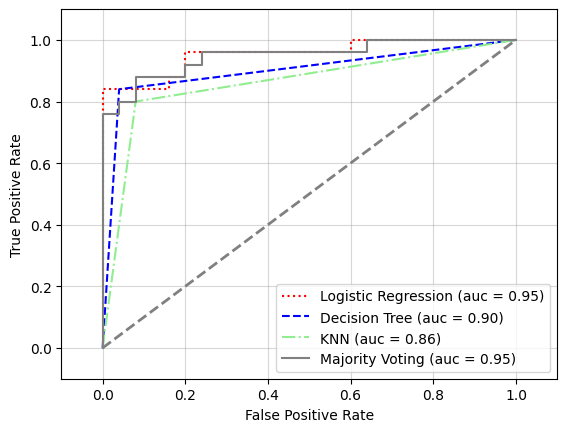

In [11]:
# import roc_curve and auc
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

# define 4 colors
colors = ['red', 'blue', 'lightgreen', 'gray']
# define 4 line styles
line_styles = [':', '--', '-.', '-']

for clf, label, clr, ls in  zip(all_clf, clf_labels, colors, line_styles):
    # calculate fpr, tpr, threholds
    y_pred = clf.fit(X_train, y_train).predict_proba(X_test)[:, 1]
    fpr, tpr, thresholds = roc_curve(y_true=y_test, y_score=y_pred)
    
    # calculate roc auc
    roc_auc = auc(x=fpr, y=tpr)
    # plot
    plt.plot(fpr, tpr, color=clr, linestyle=ls, label=f'{label} (auc = {roc_auc:.2f})')
    
plt.legend(loc='lower right')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', linewidth=2)
plt.xlim([-0.1, 1.1])
plt.ylim([-0.1, 1.1])
plt.grid(alpha=0.5)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

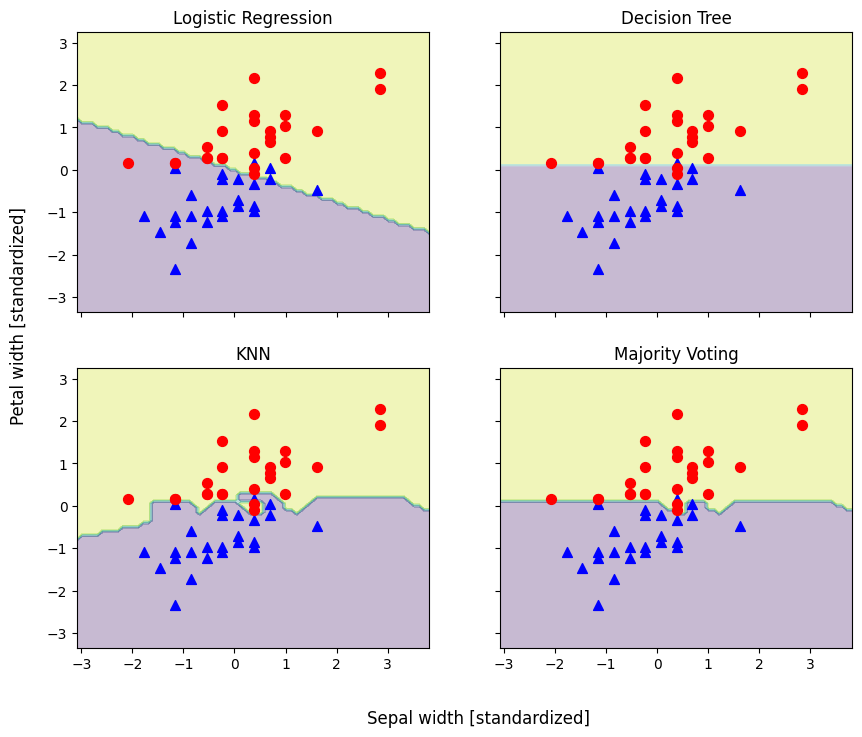

In [14]:
sc = StandardScaler()
X_train_std = sc.fit_transform(X_train)

from itertools import product

x_min = X_train_std[:, 0].min() - 1
x_max = X_train_std[:, 0].max() + 1

y_min = X_train_std[:, 1].min() - 1
y_max = X_train_std[:, 1].max() + 1

xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1), np.arange(y_min, y_max, 0.1))
f, axarr = plt.subplots(nrows=2, ncols=2, sharex='col', sharey='row', figsize=(10, 8))

for idx, clf, tt in zip(product([0, 1], [0, 1]), all_clf, clf_labels):
    clf.fit(X_train_std, y_train)
    
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    
    axarr[idx[0], idx[1]].contourf(xx, yy, Z, alpha=0.3)
    
    axarr[idx[0], idx[1]].scatter(X_train_std[y_train==0, 0], X_train_std[y_train==0, 1], c='blue', marker='^', s=50)
    
    axarr[idx[0], idx[1]].scatter(X_train_std[y_train==1, 0], X_train_std[y_train==1, 1], c='red', marker='o', s=50)
    
    axarr[idx[0], idx[1]].set_title(tt)
    
plt.text(x=-3.5, y=-5, s='Sepal width [standardized]', ha='center', va='center', fontsize=12)
plt.text(x=-12.5, y=4.5, s='Petal width [standardized]', ha='center', va='center', fontsize=12, rotation=90)

plt.show()

In [15]:
# import GridSearchCV
from sklearn.model_selection import GridSearchCV
param_grid = {
    'decisiontreeclassifier__max_depth': [1, 2],
    'pipeline-1__clf__C': [0.001, 0.1, 100.0],
}

grid = GridSearchCV(estimator=mv_clf, param_grid=param_grid, cv=10, scoring='roc_auc')
grid.fit(X_train, y_train)

for mean, std, params in zip(grid.cv_results_['mean_test_score'], grid.cv_results_['std_test_score'], grid.cv_results_['params']):
    print(f'{mean:.3f} (+/- {std * 2:.3f}) for {params}')

0.983 (+/- 0.100) for {'decisiontreeclassifier__max_depth': 1, 'pipeline-1__clf__C': 0.001}
0.983 (+/- 0.100) for {'decisiontreeclassifier__max_depth': 1, 'pipeline-1__clf__C': 0.1}
0.967 (+/- 0.200) for {'decisiontreeclassifier__max_depth': 1, 'pipeline-1__clf__C': 100.0}
0.983 (+/- 0.100) for {'decisiontreeclassifier__max_depth': 2, 'pipeline-1__clf__C': 0.001}
0.983 (+/- 0.100) for {'decisiontreeclassifier__max_depth': 2, 'pipeline-1__clf__C': 0.1}
0.967 (+/- 0.200) for {'decisiontreeclassifier__max_depth': 2, 'pipeline-1__clf__C': 100.0}


In [16]:
# print best param and best score
print(f'Best parameters: {grid.best_params_}')
print(f'Best ROC AUC score: {grid.best_score_:.3f}')

Best parameters: {'decisiontreeclassifier__max_depth': 1, 'pipeline-1__clf__C': 0.001}
Best cross-validation score: 0.983
